In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict
import Bio.PDB.Polypeptide as pp
from os.path import join
import os
from main_functions import *

In [2]:
DATA = 'data/'

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
plt.rcParams["figure.facecolor"] = 'white'
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['ytick.minor.width'] = 0.5

### Functional Data

In [5]:
proteins = ['1be9', '1d5r', '1nd4', '3dqw', '4bz3']
protein_names = ['PSD95', 'PTEN', 'APH(3\')II', 'Src CD', 'VIM-2']
measures = ['nodes', 'edges', 'weight', 'distance']

In [6]:
functional_data = dict()
for protein in proteins:
    csv_file = join(DATA, f'functional_{protein}.csv')
    functional_data[protein] = pd.read_csv(csv_file, index_col=0, header=0)

### Perturbation Network Data and Related Functions

In [7]:
data_path = join(DATA, 'structure')
thresholds = [round(i, 1) for i in np.linspace(3, 10, 71)]
sample_thresholds = [round(i, 1) for i in np.linspace(3, 10, 8)]

In [8]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

In [9]:
def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

In [10]:
fig_width_in = round(440.84746/72.27,1)

### Precision and Recall vs Position Percentages

Compare precision scores with functional percentage, leaving parameters fixed at [1,1,1] and mincount of 2; 
    and recall scores with prediction percentage, leaving functional percentage fixed at 40%, mincount fixed at 2,
    and varying the functional cutoffs from 1 to 2. Considering loss of function predictions. 

In [11]:
# list to save data, values will be (percentage, score, type, protein)
data_pr = []

In [12]:
# Precision and recall prediction percentage    
cutoffs = [round(i,2) for i in np.linspace(1,2,81)] # cutoffs to use to get diff prediction percentages
for i, protein in enumerate(proteins):
    recall, precision = [], []
    percentages_added = [] # Keep track of percentages to avoid repeats with different scores when rounding
    n = len(functional_data[protein].columns)
    prediction_percentage = []
    funct_extremes = GetPercentage(0.4, 'lowest', functional_data[protein])
    for cutoff in cutoffs:
        network_extremes = GetNetworkExtremes(protein, 2, measure_cutoffs=[cutoff]*3)
        how_many = funct_extremes.intersection(network_extremes)
        percentage = round(ToPercentage(network_extremes, n), 0)
        score_prc = ToPercentage(how_many, network_extremes)
        score_rec = ToPercentage(how_many, funct_extremes)
        if percentage not in percentages_added:
            data_pr.append((percentage, score_prc, "Precision - SSP", protein_names[i]))
            data_pr.append((percentage, score_rec, "Recall - SSP", protein_names[i]))
            percentages_added.append(percentage)

In [13]:
# Precision and functional percentage
percentage_range = [round(i,2) for i in np.linspace(0.3, 0.7, 41)] # diff funct percentages to test
for i, protein in enumerate(proteins):
    network_extremes = GetNetworkExtremes(protein, 2, [1,1,1])
    for percentage in percentage_range:
        funct_extremes = GetPercentage(percentage, 'lowest', functional_data[protein])
        how_many = funct_extremes.intersection(network_extremes)
        score = ToPercentage(how_many, network_extremes)
        data_pr.append((round(percentage*100,0), score, "Precision - FSP", protein_names[i]))

In [14]:
# Recall and functional percentage
for i, protein in enumerate(proteins):
    recall = []
    network_extremes = GetNetworkExtremes(protein, 2, [1,1,1])
    for percentage in percentage_range:
        funct_extremes = GetPercentage(percentage, 'lowest', functional_data[protein])
        how_many = funct_extremes.intersection(network_extremes)
        score = ToPercentage(how_many, funct_extremes)
        data_pr.append((round(percentage*100,0), score, "Recall - FSP", protein_names[i]))

In [15]:
data_pr = pd.Series(data_pr).drop_duplicates().tolist()

In [16]:
df2 = pd.DataFrame(data_pr, columns=['Percentage', 'Score', 'Type', 'Protein'])

In [17]:
for protein in protein_names:
    pers = df2.loc[(df2['Type']=='Precision - SSP') & (df2['Protein']==protein), 'Percentage'].tolist()
    scores = df2.loc[(df2['Type']=='Precision - SSP') & (df2['Protein']==protein), 'Score'].tolist()
    pairs = [i for i in zip(pers, scores)]
    pairs.sort()
    pairs = np.array(pairs)
    per_range = np.arange(pairs[0][0], pairs[-1][0])
    # Fill in missing values with linear interpolation
    lin_interp = np.interp(per_range, pairs[:,0], pairs[:,1])
    # Add missing values to dataframe
    for i, percentage in enumerate(per_range):
        if percentage not in pairs:
            df2.loc[len(df2)] = [percentage, lin_interp[i], 'Precision - SSP', protein]

In [22]:
df2[df2.Type=='Precision - SSP'].groupby('Percentage')['Score'].mean()

Percentage
18.0    87.000000
19.0    83.700000
20.0    84.600000
21.0    85.200000
22.0    85.500000
23.0    84.700000
24.0    83.900000
25.0    82.800000
26.0    81.800000
27.0    76.050000
28.0    78.433333
29.0    78.775000
30.0    75.920000
31.0    74.760000
32.0    74.380000
33.0    74.070000
34.0    73.600000
35.0    73.440000
36.0    73.300000
37.0    72.840000
38.0    72.930000
39.0    72.560000
40.0    71.830000
41.0    70.620000
42.0    69.850000
43.0    69.225000
44.0    69.025000
45.0    68.500000
46.0    67.650000
47.0    66.900000
48.0    66.475000
49.0    65.991667
50.0    64.144444
51.0    63.866667
52.0    64.350000
53.0    56.600000
54.0    55.550000
55.0    54.500000
Name: Score, dtype: float64

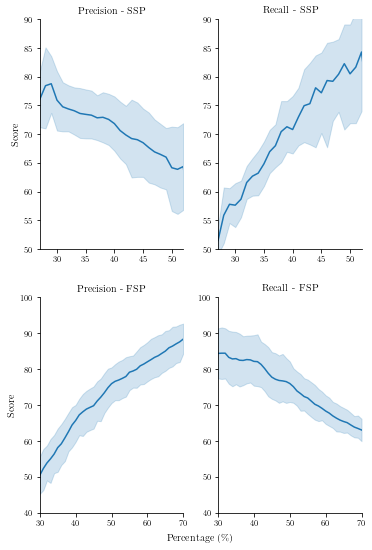

In [18]:
g2 = sns.FacetGrid(data=df2, col="Type", sharex=False, sharey=False, col_wrap=2, height=4, aspect=0.66)
g2.map(sns.lineplot, "Percentage", "Score")
g2.set_titles(row_template = '{row_name}', col_template = '{col_name}', fontsize=10)
g2.set_axis_labels("", "Score", fontsize=10)
g2.fig.text(0.45,0.03, "Percentage (\%)", fontsize=10)

for i, ax in enumerate(g2.axes.flat):
    ax.set_aspect(1)
    if i in [0,1]:
        ax.set_xlim(27,52)
        ax.set_ylim(50,90)
        ax.set_xticks([30, 35, 40, 45, 50])
    else:
        ax.set_xlim(30,70)
        ax.set_ylim(40,100)
        
plt.subplots_adjust(hspace=-0.2)
plt.tight_layout()
    
#g2.savefig('figures/behavior2.png', dpi=300)

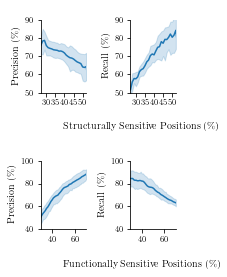

In [23]:
g2 = sns.FacetGrid(data=df2, col="Type", sharex=False, sharey=False, col_wrap=2, height=4, aspect=.66)
g2.map(sns.lineplot, "Percentage", "Score")
g2.set_titles(col_template = ' ')

g2.fig.text(0.35,0.01, "Functionally Sensitive Positions (\%)", fontsize=10)
g2.fig.text(0.35,0.49, "Structurally Sensitive Positions (\%)", fontsize=10)

for i, ax in enumerate(g2.axes.flat):
    ax.set_aspect(1)
    ax.set_xlabel("")
    if i in [0,1]:
        ax.set_xlim(27,52)
        ax.set_ylim(50,90)
        ax.set_xticks([30, 35, 40, 45, 50])
    else:
        ax.set_xlim(30,70)
        ax.set_ylim(40,100)

    if i in [0, 2]:
        ax.set_ylabel("Precision (\%)")
    else:
        ax.set_ylabel("Recall (\%)")
        
plt.subplots_adjust(hspace=0.6, wspace=0.4)
plt.tight_layout()


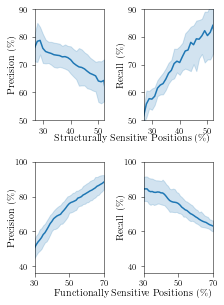

In [106]:
fig, axes = plt.subplots(2,2, figsize=(3, 4.2), constrained_layout=True)

sns.lineplot(x='Percentage', y='Score', data=df2[df2.Type=='Precision - SSP'], ax=axes[0,0])
sns.lineplot(x='Percentage', y='Score', data=df2[df2.Type=='Recall - SSP'], ax=axes[0,1])
sns.lineplot(x='Percentage', y='Score', data=df2[df2.Type=='Precision - FSP'], ax=axes[1,0])
sns.lineplot(x='Percentage', y='Score', data=df2[df2.Type=='Recall - FSP'], ax=axes[1,1])

for a in [axes[0,0], axes[0,1]]:
    a.set_xlim(27,52)
    a.set_ylim(50,90)
    a.set_xticks([30, 40, 50])
    a.set_yticks([50, 60, 70, 80, 90])
    
for a in [axes[1,0], axes[1,1]]:
    a.set_xlim(30,70)
    a.set_ylim(36,100)
    a.set_xticks([30, 50, 70])
    a.set_yticks([40, 60, 80, 100])
    
for a in [axes[0,0], axes[1,0]]:
    t = a.text(-0.25, 0.5, 'Precision (\%)', rotation=90, verticalalignment='center', horizontalalignment='right', 
            transform=a.transAxes)
    
for a in [axes[0,1], axes[1,1]]:
    t = a.text(-0.25, 0.5, 'Recall (\%)', rotation=90, verticalalignment='center', horizontalalignment='right', 
            transform=a.transAxes)
    
for a in [axes[0,0], axes[0,1], axes[1,0], axes[1,1]]:
    a.set_aspect(1)
    a.set_xlabel('%')
    a.set_ylabel('')
    
fig.text(0.23,-0.01, "Functionally Sensitive Positions (\%)", fontsize=10)
fig.text(0.23,0.5, "Structurally Sensitive Positions (\%)", fontsize=10)

fig.savefig('figures/behavior.png', dpi=300, bbox_inches='tight')

## Predictions for single measure

In [92]:
def NetworkExtremesOneMeasure(protein, measure, cutoff, threshold):
    """ Return set with positions that have mutations that pass measure cutoff. """
    network_df = Standardize(protein, threshold, measure)
    extremes = network_df.columns[(network_df > cutoff).any()].tolist()
    return set(extremes)

In [93]:
def dataOneMeasure(cutoff):
    """Loss of function predictions based only on one measure. """
    index = pd.MultiIndex.from_product([proteins, measures, ["Precision", "Recall"]], 
                                       names=["Protein", "Measure", "Score"])
    df = pd.DataFrame(index=index, columns=thresholds)
    
    for j, measure in enumerate(measures):
        for i, protein in enumerate(proteins):
            funct_extremes = GetPercentage(0.4, 'lowest', functional_data[protein])
            
            for threshold in thresholds:
                # positions predicted
                predictions = NetworkExtremesOneMeasure(protein, measure, cutoff, threshold)
                # positions in intersection between predictions and funct_extremes 
                how_many = predictions.intersection(funct_extremes)
                df.at[(protein, measure, "Precision"), threshold] = ToPercentage(how_many, predictions)
                df.at[(protein, measure, "Recall"), threshold] = ToPercentage(how_many, funct_extremes)
    return df

In [94]:
dataOne = dataOneMeasure(1.5)

In [102]:
def PredictionsOneMeasure(df):
    """Loss of function predictions based only on one measure, to find best threshold per measure. Takes DataFrame 
    from dataOneMeasure."""
    fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(fig_width_in,0.8*fig_width_in), sharex=True, sharey=True)
    
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.xlabel('Thresholds (\AA{})', fontsize=8)
    fig.text(0.01, 0.4, "Percentage (\%)", rotation=90, fontsize=8)
    
    for j, measure in enumerate(measures):
        for i, protein in enumerate(proteins):
            precision = df.loc[(protein, measure, "Precision"), :].values.tolist()
            recall = df.loc[(protein, measure, "Recall"), :].values.tolist()

            ax = axes[j, i]
            ax.set_xlim(3,10)
            ax.set_xticks([4,6,8,10])
            ax.set_ylim(0,100)
            ax.tick_params(width=0.5)
            ax.plot(thresholds, precision, color='#20b2aa', marker='o', ms=0, markeredgewidth=0.0, linewidth=1,  
                     label='Precision')
            ax.plot(thresholds, recall, color='#ffc3a0', marker='o', ms=0, markeredgewidth=0.0, linewidth=1, 
                     label='Recall')

            if i == 0:
                if measure == 'distance':
                    name = 'Diameter' ## change label 
                else:
                    name = measure.capitalize()
                ax.set_ylabel(name, fontsize=8)
            if j == 0:
                ax.set_title(protein_names[i], fontsize=10)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=(0, 0.93), loc='lower left', ncol=2, frameon=False)
    fig.subplots_adjust(hspace=0.15, wspace=0.15)
    
    return fig

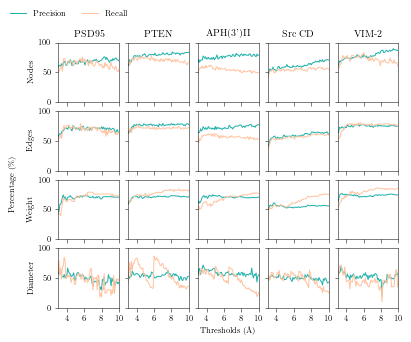

In [107]:
fig = PredictionsOneMeasure(dataOne)
fig.savefig('figures/one_measure_fit.png', dpi=300)

In [23]:
dataOne = dataOne.astype('float64') 

In [24]:
# obtaining best and worst scores for precision
all_prc = dataOne[dataOne.index.get_level_values('Score').isin(['Precision'])].mean(axis=1)
for measure in measures:
    mean = all_prc[all_prc.index.get_level_values('Measure').isin([measure])].mean()
    print(measure, mean)

nodes 72.66140845070424
edges 70.4425352112676
weight 67.91661971830987
distance 52.57521126760563


In [25]:
## obtaining best and worst scores for recall
all_rec = dataOne[dataOne.index.get_level_values('Score').isin(['Recall'])].mean(axis=1)
for measure in measures:
    mean = all_rec[all_rec.index.get_level_values('Measure').isin([measure])].mean()
    print(measure, mean)

nodes 62.815492957746486
edges 65.51661971830988
weight 71.76366197183101
distance 49.01971830985916


In [27]:
dataOne[dataOne.index.get_level_values('Score').isin(['Precision'])].idxmax(axis=1)

Protein  Measure   Score    
1be9     nodes     Precision    8.3
         edges     Precision    4.7
         weight    Precision    3.6
         distance  Precision    4.1
1d5r     nodes     Precision    8.1
         edges     Precision    8.0
         weight    Precision    8.0
         distance  Precision    7.6
1nd4     nodes     Precision    7.4
         edges     Precision    9.1
         weight    Precision    4.7
         distance  Precision    3.6
3dqw     nodes     Precision    9.8
         edges     Precision    8.1
         weight    Precision    3.7
         distance  Precision    4.3
4bz3     nodes     Precision    9.4
         edges     Precision    5.9
         weight    Precision    3.5
         distance  Precision    3.4
dtype: float64

In [28]:
## threshold with greatest mean precision over measures nodes, edges, weight
all_prc = dataOne[dataOne.index.get_level_values('Score').isin(['Precision'])]
all_prc[all_prc.index.get_level_values('Measure').isin(['nodes', 'edges', 'weight'])].mean().idxmax()

9.3

In [29]:
## threshold with greatest mean recall over measures nodes, edges, weight
all_rec = dataOne[dataOne.index.get_level_values('Score').isin(['Recall'])]
all_rec[all_rec.index.get_level_values('Measure').isin(['nodes', 'edges', 'weight'])].mean().idxmax()

8.4

In [30]:
## threshold with greatest mean over measure distance
dataOne[dataOne.index.get_level_values('Measure').isin(['distance'])].mean().idxmax()

3.8

### Comparing perturbation cutoffs with precision and recall scores

In [60]:
# Percentages obtained for different minimum counts at cutoffs 1 and 2
for mincount in [1,2,3]:
    percentages = []
    for cutoff in [1,2]:
        scores = []
        for protein in proteins:
            network_extremes = GetNetworkExtremes(protein, mincount, [cutoff]*3)
            positions = len(functional_data[protein].columns)

            ssps = ToPercentage(network_extremes, positions)
            scores.append(ssps)
            
        percentages.append(round(np.mean(scores), 2))
    print(f"Min. count = {mincount}", percentages)   

Min. count = 1 [63.22, 38.72]
Min. count = 2 [50.0, 26.62]
Min. count = 3 [39.1, 15.14]


In [108]:
def GetScores(functional_percentage, network_mincount, measure_cutoffs, thresh=9.0, mean=True):
    """Return precision, recall and prediction percentage scores. Returns list of lists, [precision, recall,
    predper] for each protein and the mean, if mean == True """
    which_scores = ['Precision', 'Recall', 'Improvement', 'SSPs']
    scores = {score:[] for score in which_scores}
    for protein in proteins:
        network_extremes = GetNetworkExtremes(protein, network_mincount, measure_cutoffs, thresh=thresh)
        funct_extremes = GetPercentage(functional_percentage, 'lowest', functional_data[protein])
        how_many = len(network_extremes.intersection(funct_extremes))
        positions = len(functional_data[protein].columns)
    
        scores['Recall'].append(ToPercentage(how_many, funct_extremes))
        precision_score = ToPercentage(how_many, network_extremes)
        scores['Precision'].append(precision_score)
        scores['Improvement'].append(round(precision_score/40, 2))
        ssps = ToPercentage(network_extremes, positions)
        scores['SSPs'].append(ssps)
        
    if mean:
        for score in which_scores:
            scores[score].append(round(np.mean(scores[score]), 2))
            
    return scores

In [109]:
def dataCompare(functional_cutoff, network_mincount, thresh=9.0):
    """Obtain data to compare Precision and Recall scores for range of measure cutoffs, considering same cutoff for 
    four measures, ranging from 1 to 2. Considering loss of function predictions."""
    cutoffs = [x for x in np.linspace(1,2,51)]
    
    index = pd.MultiIndex.from_product([proteins, ["Precision", "Recall"]], names=["Protein", "Measure"])
    df = pd.DataFrame(index=index, columns=cutoffs)
    
    for protein in proteins:
        funct_extremes = GetPercentage(functional_cutoff, 'lowest', functional_data[protein])
        for cutoff in cutoffs:
            measure_cutoffs = [cutoff]*3
            network_extremes = GetNetworkExtremes(protein, network_mincount, measure_cutoffs, thresh=thresh)
            how_many = network_extremes.intersection(funct_extremes)
            df.at[(protein, "Precision"), cutoff] = ToPercentage(how_many, network_extremes)
            df.at[(protein, "Recall"), cutoff] = ToPercentage(how_many, funct_extremes)
           
    return df

In [110]:
def ComparePR(df_list):
    """Compare Precision and Recall scores for range of measure cutoffs, returns plot. Based on df resulting 
    from dataCompare, can take 1 or multiple. Input as list of DataFrames. """
    
    n = len(df_list)
        
    fig, axes = plt.subplots(nrows=n, ncols=5, figsize=(fig_width_in,(0.2*fig_width_in*n)), sharex=True, sharey=True)
    
    fig.text(0.01, 0.4, "Percentage (\%)", rotation=90, fontsize=8)
    fig.text(0.47, 0.03, "Cutoffs", fontsize=8)
    
    ax = plt.gca()
    ax.xaxis.set_label_coords(0.5, -0.1) if n == 1 else ax.yaxis.set_label_coords(-0.01, 0.5)
    ax.yaxis.set_label_coords(-0.05, 0.5) if n != 1 else ax.yaxis.set_label_coords(-0.03, 0.5)
    
    cutoffs = [x for x in np.linspace(1,2,51)]
    
    for j, df in enumerate(df_list):
        for i, protein in enumerate(proteins):
            precision, recall = [], []
            precision = df.loc[(protein, "Precision"), :].values.tolist()
            recall = df.loc[(protein, "Recall"), :].values.tolist()

            ax = axes[j,i] if n != 1 else axes[i]
            ax.set_xlim(1,2)
            ax.set_xticks([1,1.5,2])
            ax.set_xticklabels([1, 1.5, 2])
            ax.set_ylim(0,100)

            ax.plot(cutoffs, precision, color='#20b2aa', markeredgewidth=0.0, linewidth=1, label='Precision')
            ax.plot(cutoffs, recall, color='#ffc3a0', markeredgewidth=0.0, linewidth=1, label='Recall')
            
            #ax.set_aspect(1./ax.get_data_ratio())
            
            if j == 0:
                ax.set_title(protein_names[i], fontsize=10)
            if i == 0 and n != 1:
                ax.set_ylabel(f"Min. count = {j+1}", fontsize=8)
    
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=(0, 0.93), loc='lower left', ncol=2, frameon=False)
    fig.subplots_adjust(hspace=0.15, wspace=0.15)
        
    return fig

In [111]:
compare1 = dataCompare(0.4,1)
compare2 = dataCompare(0.4,2)
compare3 = dataCompare(0.4,3)

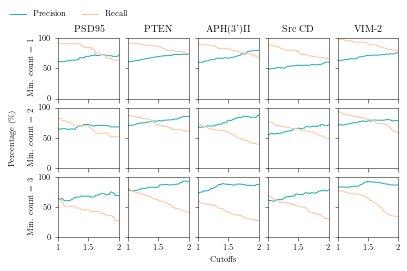

In [112]:
compare_all = ComparePR([compare1, compare2, compare3])
compare_all.savefig("figures/compare_pr_fit.png", dpi=300)

In [ ]:
compare1_fig = ComparePR([compare1])
compare1_fig.savefig("figures/compare_pr_min1.png", dpi=300)

In [ ]:
compare2_fig = ComparePR([compare2])
compare2_fig.savefig("figures/compare_pr.png", dpi=300)

In [ ]:
compare3_fig = ComparePR([compare3])
compare3_fig.savefig("figures/compare_pr_min3.png", dpi=300)

<AxesSubplot:>

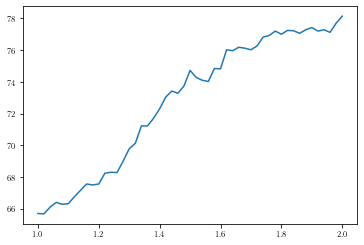

In [49]:
compare2[compare2.index.get_level_values(1)=='Precision'].mean().plot()

<AxesSubplot:>

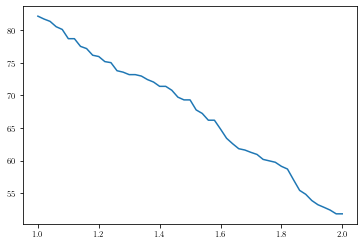

In [51]:
compare2[compare2.index.get_level_values(1)=='Recall'].mean().plot()

<AxesSubplot:>

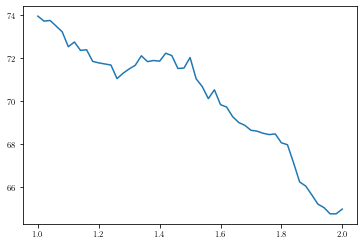

In [52]:
compare2.mean().plot()

<AxesSubplot:>

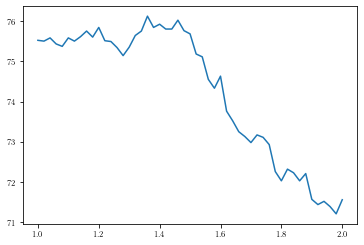

In [42]:
compare1.mean().plot()

<AxesSubplot:>

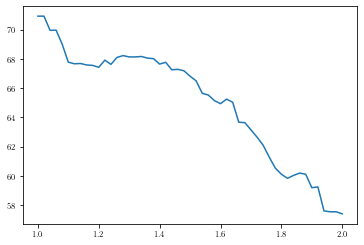

In [41]:
compare3.mean().plot()

In [33]:
### Comparing scores across different minimum counts
## mean contains mean over cutoffs, for each protein, measure and min count
index = pd.MultiIndex.from_product([proteins, ["Precision", "Recall"]], names=["Protein", "Measure"])
mean = pd.DataFrame(index=index, columns=[1,2,3])

for i,data in enumerate([compare1, compare2, compare3]):
    mean[i+1] = data.mean(axis=1)

In [34]:
mean

1          2          3
Protein Measure                                   
1be9    Precision  67.845098  68.215686  67.496078
        Recall     80.798039  65.423529  44.509804
1d5r    Precision  68.603922  77.849020  84.521569
        Recall     84.454902  73.400000  60.821569
1nd4    Precision  69.280392  77.090196  84.254902
        Recall     81.100000  56.172549  42.680392
3dqw    Precision  54.215686  64.076471  69.480392
        Recall     76.694118  63.352941  50.060784
4bz3    Precision  69.870588  76.650980  87.229412
        Recall     89.854902  78.772549  59.294118

In [35]:
## Mean precision for each min count
mean[mean.index.get_level_values("Measure").isin(['Precision'])].mean()

1    65.963137
2    72.776471
3    78.596471
dtype: float64

In [36]:
## Mean recall for each min count
mean[mean.index.get_level_values("Measure").isin(['Recall'])].mean()

1    82.580392
2    67.424314
3    51.473333
dtype: float64